# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) models.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from scipy import stats
from datetime import date
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr):
    #calculate sums
    summary_table = prob_pred_enc_lr.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_throat_admitted',
            event_col='event_throat_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [9]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [10]:
def lr_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)

    #save prob_pred_enc_lr for analysis in r
    prob_pred_enc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [11]:
def lr_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of lr models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [12]:
def calibration_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):
    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #create dataframe of predictions
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)
data_throat_13 = proc_infec_data(data,13)
data_throat_14 = proc_infec_data(data,14)
data_throat_15 = proc_infec_data(data,15)
data_throat_16 = proc_infec_data(data,16)
data_throat_17 = proc_infec_data(data,17)
data_throat_18 = proc_infec_data(data,18)
data_throat_19 = proc_infec_data(data,19)
data_throat_20 = proc_infec_data(data,20)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12, data_throat_13, data_throat_14, data_throat_15, data_throat_16, data_throat_17, data_throat_18, data_throat_19, data_throat_20])
data_throat.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] 
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_throat.loc[(data_throat['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_throat.loc[((data_throat['date'] >= '2020-05') & (data_throat['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_throat.loc[(data_throat['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

#drop any row with nan in period column
data_throat = data_throat[data_throat['period'].notna()]

#### event and duration

In [18]:
#scenario 1
#not hosped (nothing happened)
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0

In [19]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]

In [20]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [21]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30

#give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

In [22]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [23]:
#drop anybody with age less than 18 or 0!
data_throat = data_throat[~(data_throat['age'] < 18)] 
data_throat['age'][data_throat['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

In [24]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking": dict_smoking})

In [25]:
#drop rows with missing region
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
   data_throat = data_throat[data_throat['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_throat.columns) and (data_throat['smoking'].isnull().sum() > 0):
    data_throat['smoking'] = data_throat['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    data_throat['imd'] = data_throat['imd'].fillna(0)

In [26]:
#missing values of bmi assign 5 and 0; categorise bmi
data_throat['bmi_cat'] = 5

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 30:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 25) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 30):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 18.5) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 25):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 18.5:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

In [27]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])
#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [28]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [29]:
#categorise CCI
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

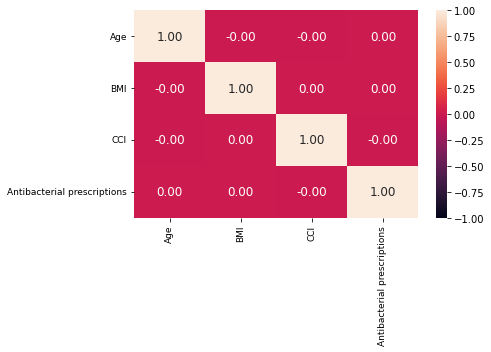

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [31]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date', 'period',
                                   'event_throat_admitted', 'duration_throat_admitted'
                                    ]]

In [32]:
#switch variable throat_ab_date into a binary variable
data_throat[['ab_binary']] = data_throat[['throat_ab_date']].where(data_throat[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]

#no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat_incdt[data_throat_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat_incdt[data_throat_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat_prevl[data_throat_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat_prevl[data_throat_prevl['ab_binary'] == 1]

In [33]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_throat_incdt_prepandemic = data_throat_incdt[data_throat_incdt['period'] == 'prepandemic']
data_throat_incdt_during_pandemic = data_throat_incdt[(data_throat_incdt['period'] == 'during_pandemic')]
data_throat_incdt_post_2nd_lockdown = data_throat_incdt[data_throat_incdt['period'] == 'post_2nd_lockdown']
data_throat_prevl_prepandemic = data_throat_prevl[data_throat_prevl['period'] == 'prepandemic']
data_throat_prevl_during_pandemic = data_throat_prevl[(data_throat_prevl['period'] == 'during_pandemic')]
data_throat_prevl_post_2nd_lockdown = data_throat_prevl[data_throat_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_throat_no_abs_incdt_prepandemic = data_throat_incdt_prepandemic[data_throat_incdt_prepandemic['ab_binary'] == 0]
data_throat_no_abs_incdt_during_pandemic = data_throat_incdt_during_pandemic[data_throat_incdt_during_pandemic['ab_binary'] == 0]
data_throat_no_abs_incdt_post_2nd_lockdown = data_throat_incdt_post_2nd_lockdown[data_throat_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_throat_no_abs_prevl_prepandemic = data_throat_prevl_prepandemic[data_throat_prevl_prepandemic['ab_binary'] == 0]
data_throat_no_abs_prevl_during_pandemic = data_throat_prevl_during_pandemic[data_throat_prevl_during_pandemic['ab_binary'] == 0]
data_throat_no_abs_prevl_post_2nd_lockdown = data_throat_prevl_post_2nd_lockdown[data_throat_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [34]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [35]:
#make summary tables
make_summary_table('throat', 'no_abs_incdt', data_throat_no_abs_incdt)
make_summary_table('throat', 'abs_incdt', data_throat_abs_incdt)
make_summary_table('throat', 'no_abs_prevl', data_throat_no_abs_prevl)
make_summary_table('throat', 'abs_prevl', data_throat_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 103599 total observations, 102882 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 103599
number of events observed = 717
   partial log-likelihood = -8261.07
         time fit was run = 2023-10-18 11:40:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.12            -0.19             0.27                 0.83                 1.31
CCI_cat[T.medium]                0.27       1.31       0.12             0.03             0.52                 1.03                 1.68
CCI_cat[T.high]                  0.30       1.36       0.14             0.02             0.59                 1.02                 1.80
CCI_cat[T.very_high]             0.19       1.21       0.13            -0.07             0.45                 0.93                 1.56
age_cat[T.25_34]                 0.16       1.17       0.14            -0.12             0.44                 0.88                 1.55
age_cat[T.35_44]                 0.22       1.25       0.14            -0.06             0.50                 0.95                 1.65
age_cat[T.45_54]                 0.23       1.26       0.14            -0.04             0.51                 0.96                 1.67
age_cat[T.55_64]                -0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
age_cat[T.65_74]                 0.15       1.16       0.14            -0.14             0.43                 0.87                 1.54
age_cat[T.75_more]               0.14       1.15       0.14            -0.15             0.42                 0.86                 1.52
antibacterial_brit              -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
bmi_cat[T.obese]                 0.07       1.08       0.15            -0.21             0.36                 0.81                 1.44
bmi_cat[T.overweight]            0.05       1.05       0.18            -0.30             0.40                 0.74                 1.49
bmi_cat[T.underweight]           0.18       1.20       0.24            -0.29             0.65                 0.75                 1.92
bmi_cat[T.unknown]               0.13       1.14       0.16            -0.17             0.44                 0.84                 1.55
ethnicity[T.other]               0.11       1.12       0.19            -0.26             0.49                 0.77                 1.63
ethnicity[T.unknown]             0.05       1.05       0.16            -0.26             0.36                 0.77                 1.43
ethnicity[T.white]               0.05       1.05       0.15            -0.24             0.34                 0.78                 1.40
flu_vaccine[T.yes]               0.12       1.12       0.12            -0.12             0.35                 0.89                 1.42
imd[T.medium]                    0.05       1.05       0.12            -0.18             0.28                 0.83                 1.33
imd[T.unaffluent]                0.04       1.05       0.12            -0.19             0.28                 0.83                 1.32
imd[T.unknown]                  -0.05       0.95       0.19            -0.43             0.32                 0.65                 1.38
imd[T.very_affluent]            -0.08       0.92       0.12            -0.33             0.16                 0.72                 1.17
imd[T.very_unaffluent]          -0.07       0.93       0.12            -0.31             0.17                 0.73                 1.19
region[T.east_midlands]          0.30       1.35       0.18  

13027


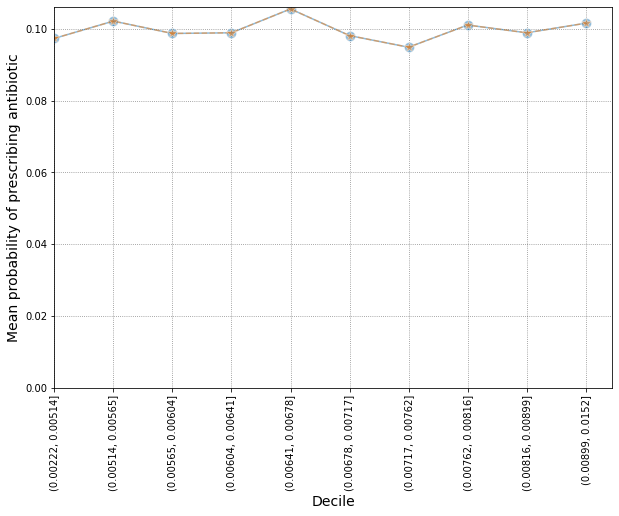


AUROC of LR for deciles with development and validation data: 0.50925 and 0.50500
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00514, 0.00565]  0.048521       -0.043314        0.140356   
1  bins_(0.00565, 0.00604]  0.011020       -0.082649        0.104690   
2  bins_(0.00604, 0.00641]  0.034623       -0.049062        0.118308   
3  bins_(0.00641, 0.00678]  0.080630       -0.000382        0.161641   
4  bins_(0.00678, 0.00717]  0.041331       -0.048307        0.130969   
5  bins_(0.00717, 0.00762] -0.034650       -0.124216        0.054915   
6  bins_(0.00762, 0.00816]  0.072986       -0.009183        0.155154   
7  bins_(0.00816, 0.00899]  0.026451       -0.061826        0.114729   
8   bins_(0.00899, 0.0152]  0.048414       -0.044004        0.140832   

         or  or_lower_95%  or_upper_95%  
0  1.049717      0.957611      1.150683  
1  1.011081      0.920674      1.110366  
2  1.035229      0.952122      1.125591  
3  1.083969    

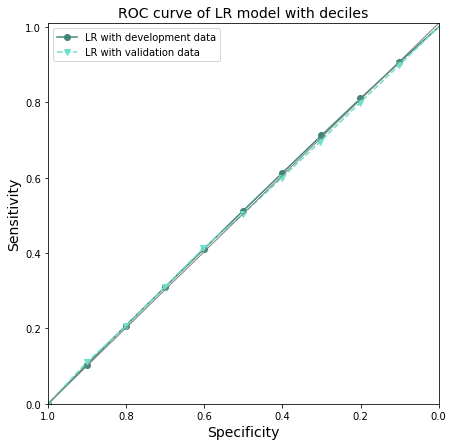

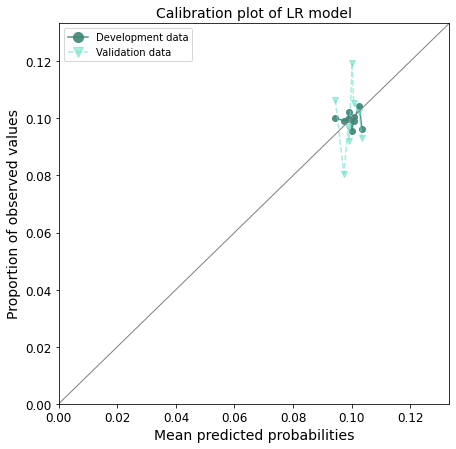


AUROC of LR for risk factors with development and validation data: 0.51627 and 0.49760
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.013288       -0.071901        0.045325   
1                 age_cat_35_44  0.014031       -0.059560        0.087622   
2                 age_cat_45_54 -0.023048       -0.094945        0.048849   
3                 age_cat_55_64 -0.028590       -0.104268        0.047088   
4                 age_cat_65_74 -0.029809       -0.102313        0.042695   
5               age_cat_75_more -0.044578       -0.111586        0.022430   
6                      sex_male  0.023551       -0.019790        0.066892   
7                  CCI_cat_high -0.013024       -0.087780        0.061731   
8                   CCI_cat_low  0.001951       -0.057144        0.061047   
9                CCI_cat_medium  0.016030       -0.039315        0.071375   
10            CCI_cat_very_high  0.015263       -0.0

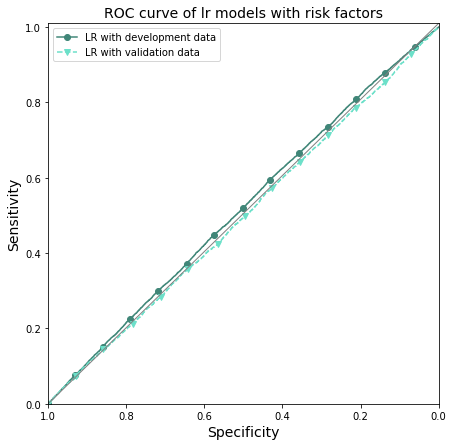

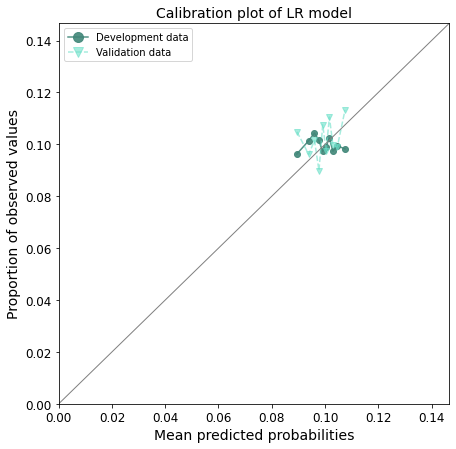

In [36]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_incdt, prob_pred_throat_no_abs_incdt_bin = cox_build('throat', 'incdt', data_throat_incdt, data_throat_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_deciles('throat', 'incdt_deciles', prob_pred_throat_no_abs_incdt)
    #calibration plots of lr with deciles
    calibration_lr('throat', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_riskfactors('throat', 'incdt_riskfactors', prob_pred_throat_no_abs_incdt)
    #calibration plots of lr with risk factors
    calibration_lr('throat', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11493 total observations, 11433 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 11493
number of events observed = 60
   partial log-likelihood = -537.81
         time fit was run = 2023-10-18 11:46:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.62       0.47            -0.43             1.39                 0.65                 4.03
CCI_cat[T.medium]                0.90       2.46       0.47            -0.03             1.83                 0.97                 6.21
CCI_cat[T.high]                  0.26       1.29       0.61            -0.93             1.45                 0.39                 4.25
CCI_cat[T.very_high]             0.67       1.95       0.51            -0.33             1.66                 0.72                 5.28
age_cat[T.25_34]                 0.02       1.02       0.50            -0.97             1.00                 0.38                 2.71
age_cat[T.35_44]                -0.10       0.90       0.52            -1.12             0.92                 0.33                 2.50
age_cat[T.45_54]                 0.72       2.05       0.43            -0.13             1.57                 0.87                 4.80
age_cat[T.55_64]                 0.02       1.02       0.50            -0.97             1.00                 0.38                 2.72
age_cat[T.65_74]                -0.02       0.98       0.50            -1.01             0.96                 0.37                 2.61
age_cat[T.75_more]              -0.47       0.62       0.57            -1.59             0.65                 0.20                 1.91
antibacterial_brit               0.10       1.11       0.09            -0.07             0.27                 0.93                 1.31
bmi_cat[T.obese]                -0.36       0.70       0.45            -1.24             0.53                 0.29                 1.71
bmi_cat[T.overweight]            0.41       1.51       0.50            -0.57             1.39                 0.56                 4.02
bmi_cat[T.underweight]          -0.75       0.47       1.08            -2.87             1.37                 0.06                 3.95
bmi_cat[T.unknown]              -0.15       0.86       0.48            -1.10             0.80                 0.33                 2.22
ethnicity[T.other]              -0.65       0.52       0.71            -2.04             0.74                 0.13                 2.11
ethnicity[T.unknown]            -0.24       0.78       0.49            -1.19             0.71                 0.30                 2.03
ethnicity[T.white]              -0.22       0.81       0.44            -1.08             0.65                 0.34                 1.92
flu_vaccine[T.yes]               0.27       1.31       0.38            -0.47             1.02                 0.62                 2.78
imd[T.medium]                   -0.70       0.50       0.55            -1.77             0.38                 0.17                 1.46
imd[T.unaffluent]                0.75       2.12       0.39            -0.01             1.52                 0.99                 4.55
imd[T.unknown]                   0.48       1.62       0.59            -0.68             1.65                 0.51                 5.20
imd[T.very_affluent]             0.27       1.31       0.42            -0.55             1.10                 0.57                 3.00
imd[T.very_unaffluent]          -0.18       0.84       0.48            -1.11             0.75                 0.33                 2.13
region[T.east_midlands]         -0.42       0.66       0.57       

13057


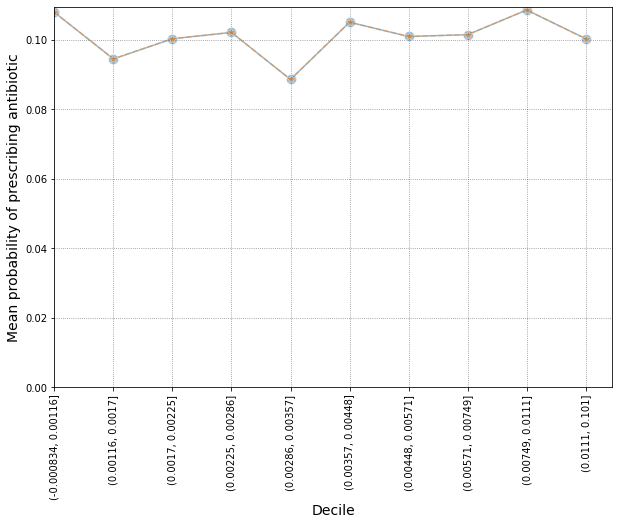


AUROC of LR for deciles with development and validation data: 0.51794 and 0.48733
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00116, 0.0017] -0.143654       -0.398354        0.111046   
1   bins_(0.0017, 0.00225] -0.066737       -0.294632        0.161158   
2  bins_(0.00225, 0.00286]  0.023191       -0.207914        0.254296   
3  bins_(0.00286, 0.00357] -0.137552       -0.373256        0.098151   
4  bins_(0.00357, 0.00448]  0.000681       -0.221018        0.222380   
5  bins_(0.00448, 0.00571] -0.115719       -0.370972        0.139535   
6  bins_(0.00571, 0.00749] -0.004555       -0.237874        0.228763   
7   bins_(0.00749, 0.0111] -0.031211       -0.270762        0.208340   
8     bins_(0.0111, 0.101]  0.043433       -0.205367        0.292232   

         or  or_lower_95%  or_upper_95%  
0  0.866188      0.671425      1.117446  
1  0.935441      0.744806      1.174870  
2  1.023462      0.812277      1.289554  
3  0.871489    

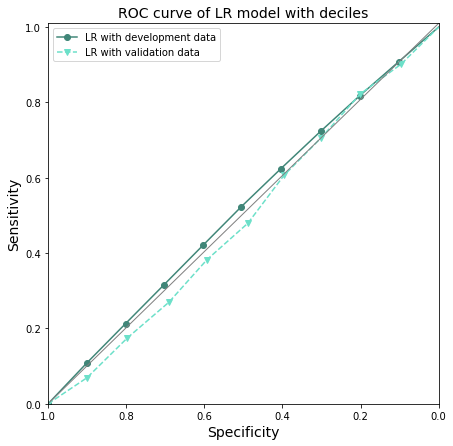

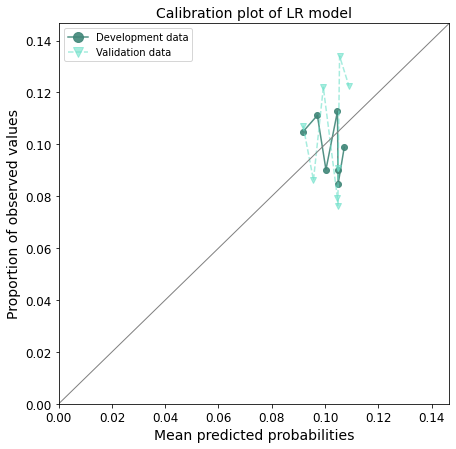


AUROC of LR for risk factors with development and validation data: 0.55158 and 0.48734
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.074706       -0.280257        0.130846   
1                 age_cat_35_44 -0.080236       -0.280846        0.120373   
2                 age_cat_45_54  0.088641       -0.122960        0.300243   
3                 age_cat_55_64 -0.063881       -0.257518        0.129755   
4                 age_cat_65_74 -0.094272       -0.301017        0.112473   
5               age_cat_75_more -0.056644       -0.243030        0.129742   
6                      sex_male -0.049549       -0.157650        0.058553   
7                  CCI_cat_high  0.014792       -0.196351        0.225934   
8                   CCI_cat_low  0.013815       -0.133338        0.160969   
9                CCI_cat_medium -0.016703       -0.193316        0.159910   
10            CCI_cat_very_high  0.102331       -0.1

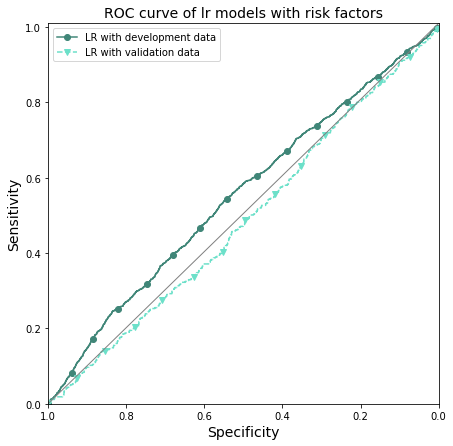

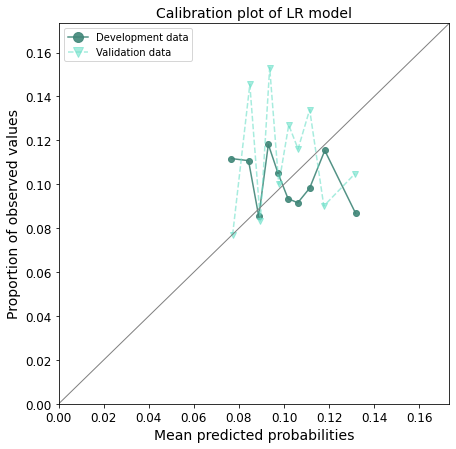

In [37]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_prevl, prob_pred_throat_no_abs_prevl_bin = cox_build('throat', 'prevl', data_throat_prevl, data_throat_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_deciles('throat', 'prevl_deciles', prob_pred_throat_no_abs_prevl)
    #calibration plots of lr with deciles
    calibration_lr('throat', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_riskfactors('throat', 'prevl_riskfactors', prob_pred_throat_no_abs_prevl)
    #calibration plots of lr with risk factors
    calibration_lr('throat', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28765 total observations, 28600 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 28765
number of events observed = 165
   partial log-likelihood = -1669.51
         time fit was run = 2023-10-18 11:47:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.26            -0.19             0.83                 0.83                 2.30
CCI_cat[T.medium]                0.57       1.77       0.27             0.04             1.10                 1.04                 3.00
CCI_cat[T.high]                  0.29       1.34       0.34            -0.36             0.95                 0.70                 2.59
CCI_cat[T.very_high]             0.40       1.48       0.29            -0.17             0.97                 0.84                 2.63
age_cat[T.25_34]                 0.13       1.13       0.27            -0.39             0.65                 0.67                 1.91
age_cat[T.35_44]                -0.21       0.81       0.29            -0.77             0.35                 0.46                 1.43
age_cat[T.45_54]                -0.29       0.75       0.30            -0.87             0.29                 0.42                 1.34
age_cat[T.55_64]                -0.67       0.51       0.33            -1.32            -0.03                 0.27                 0.97
age_cat[T.65_74]                -0.09       0.91       0.28            -0.64             0.45                 0.53                 1.57
age_cat[T.75_more]              -0.01       0.99       0.27            -0.54             0.53                 0.58                 1.69
antibacterial_brit              -0.01       0.99       0.06            -0.12             0.10                 0.89                 1.10
bmi_cat[T.obese]                 0.39       1.47       0.33            -0.26             1.04                 0.77                 2.83
bmi_cat[T.overweight]            0.39       1.47       0.39            -0.37             1.15                 0.69                 3.15
bmi_cat[T.underweight]           0.79       2.21       0.46            -0.11             1.69                 0.90                 5.44
bmi_cat[T.unknown]               0.03       1.03       0.36            -0.68             0.74                 0.51                 2.11
ethnicity[T.other]              -0.25       0.78       0.44            -1.11             0.62                 0.33                 1.86
ethnicity[T.unknown]             0.11       1.12       0.33            -0.53             0.75                 0.59                 2.12
ethnicity[T.white]               0.07       1.08       0.31            -0.53             0.67                 0.59                 1.96
flu_vaccine[T.yes]              -0.09       0.91       0.27            -0.62             0.44                 0.54                 1.56
imd[T.medium]                    0.36       1.43       0.25            -0.12             0.84                 0.88                 2.32
imd[T.unaffluent]                0.22       1.24       0.25            -0.28             0.71                 0.76                 2.04
imd[T.unknown]                   0.12       1.13       0.40            -0.67             0.91                 0.51                 2.48
imd[T.very_affluent]            -0.05       0.95       0.27            -0.58             0.49                 0.56                 1.63
imd[T.very_unaffluent]          -0.00       1.00       0.27            -0.53             0.52                 0.59                 1.68
region[T.east_midlands]         -0.14       0.87       0.39     

13060


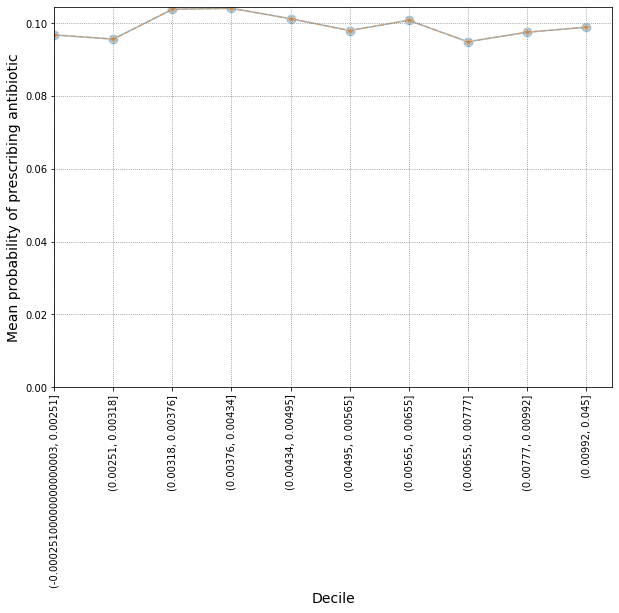


AUROC of LR for deciles with development and validation data: 0.51312 and 0.49270
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00251, 0.00318]  0.051828       -0.126876        0.230532   
1  bins_(0.00318, 0.00376]  0.107120       -0.064189        0.278429   
2  bins_(0.00376, 0.00434]  0.117249       -0.055934        0.290433   
3  bins_(0.00434, 0.00495]  0.018909       -0.161369        0.199186   
4  bins_(0.00495, 0.00565]  0.071057       -0.126448        0.268562   
5  bins_(0.00565, 0.00655]  0.084869       -0.108618        0.278356   
6  bins_(0.00655, 0.00777] -0.038440       -0.228939        0.152060   
7  bins_(0.00777, 0.00992]  0.001227       -0.156817        0.159272   
8    bins_(0.00992, 0.045]  0.070531       -0.102738        0.243800   

         or  or_lower_95%  or_upper_95%  
0  1.053195      0.880843      1.259269  
1  1.113068      0.937828      1.321053  
2  1.124400      0.945601      1.337006  
3  1.019088    

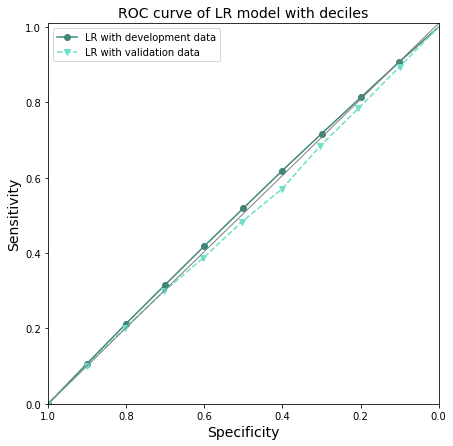

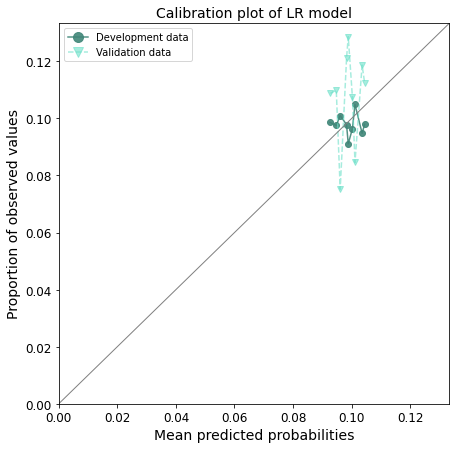

In [38]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_incdt_prepandemic, prob_pred_throat_no_abs_incdt_prepandemic_bin = cox_build('throat', 'incdt_prepandemic', data_throat_incdt_prepandemic, data_throat_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_build_risk_deciles('throat', 'incdt_prepandemic_deciles', prob_pred_throat_no_abs_incdt_prepandemic)
    #calibration plots of lr
    calibration_lr('throat', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26076 total observations, 25909 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 26076
number of events observed = 167
   partial log-likelihood = -1680.51
         time fit was run = 2023-10-18 11:47:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.24            -0.73             0.23                 0.48                 1.26
CCI_cat[T.medium]                0.08       1.09       0.25            -0.41             0.58                 0.66                 1.79
CCI_cat[T.high]                  0.36       1.43       0.28            -0.20             0.91                 0.82                 2.48
CCI_cat[T.very_high]             0.29       1.34       0.25            -0.21             0.79                 0.81                 2.20
age_cat[T.25_34]                 0.30       1.35       0.28            -0.26             0.85                 0.77                 2.35
age_cat[T.35_44]                -0.02       0.98       0.30            -0.61             0.57                 0.54                 1.77
age_cat[T.45_54]                 0.29       1.34       0.28            -0.26             0.85                 0.77                 2.34
age_cat[T.55_64]                -0.15       0.86       0.31            -0.77             0.46                 0.47                 1.59
age_cat[T.65_74]                -0.23       0.79       0.32            -0.87             0.40                 0.42                 1.49
age_cat[T.75_more]               0.27       1.31       0.28            -0.29             0.82                 0.75                 2.28
antibacterial_brit               0.03       1.03       0.05            -0.08             0.14                 0.93                 1.14
bmi_cat[T.obese]                -0.06       0.94       0.30            -0.65             0.53                 0.52                 1.69
bmi_cat[T.overweight]            0.26       1.30       0.34            -0.41             0.94                 0.66                 2.55
bmi_cat[T.underweight]          -0.10       0.91       0.53            -1.13             0.93                 0.32                 2.54
bmi_cat[T.unknown]               0.11       1.11       0.31            -0.51             0.72                 0.60                 2.06
ethnicity[T.other]              -0.18       0.84       0.36            -0.88             0.53                 0.41                 1.70
ethnicity[T.unknown]            -0.54       0.58       0.30            -1.13             0.04                 0.32                 1.05
ethnicity[T.white]              -0.25       0.78       0.26            -0.76             0.26                 0.47                 1.30
flu_vaccine[T.yes]               0.08       1.08       0.25            -0.41             0.57                 0.66                 1.76
imd[T.medium]                   -0.28       0.76       0.25            -0.76             0.20                 0.47                 1.22
imd[T.unaffluent]               -0.24       0.79       0.24            -0.71             0.24                 0.49                 1.27
imd[T.unknown]                  -0.69       0.50       0.48            -1.62             0.25                 0.20                 1.28
imd[T.very_affluent]            -0.21       0.81       0.24            -0.68             0.26                 0.51                 1.30
imd[T.very_unaffluent]          -0.17       0.85       0.24            -0.63             0.30                 0.53                 1.35
region[T.east_midlands]          0.62       1.86       0.35     

13042


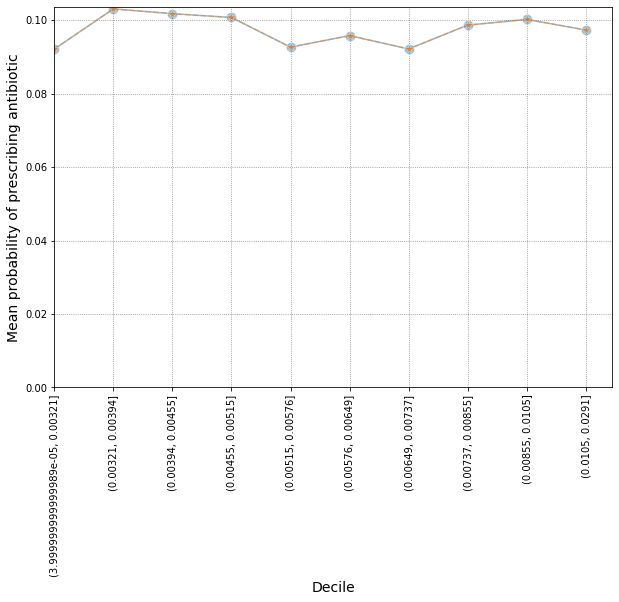


AUROC of LR for deciles with development and validation data: 0.51701 and 0.49679
LR summary:
                                covariate      coef  coef_lower_95%  \
0                bins_(0.00394, 0.00455] -0.064251       -0.238927   
1                bins_(0.00455, 0.00515] -0.031037       -0.187350   
2                bins_(0.00515, 0.00576] -0.129727       -0.296542   
3                bins_(0.00576, 0.00649] -0.136322       -0.309447   
4                bins_(0.00649, 0.00737] -0.163424       -0.331578   
5                bins_(0.00737, 0.00855] -0.043209       -0.212435   
6                 bins_(0.00855, 0.0105] -0.048759       -0.201042   
7                  bins_(0.0105, 0.0291] -0.083128       -0.244703   
8  bins_(3.999999999999989e-05, 0.00321] -0.160252       -0.345043   

   coef_upper_95%        or  or_lower_95%  or_upper_95%  
0        0.110426  0.937770      0.787472      1.116753  
1        0.125275  0.969439      0.829154      1.133460  
2        0.037088  0.878335  

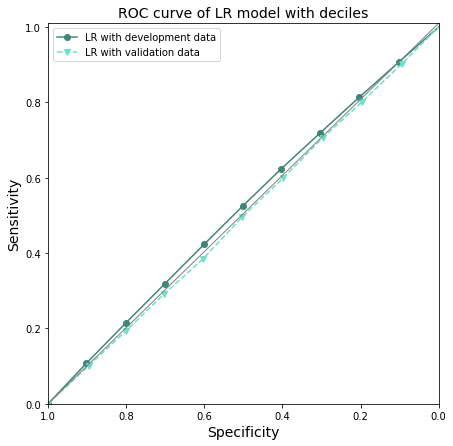

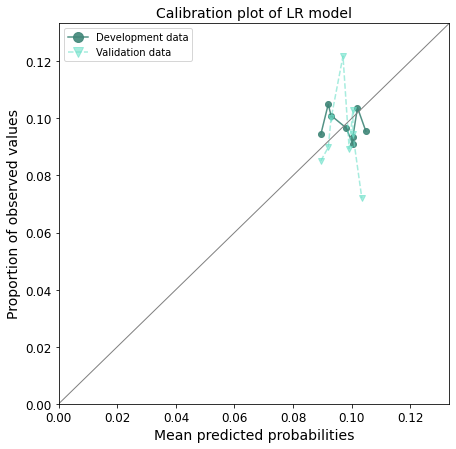

In [39]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_incdt_during_pandemic, prob_pred_throat_no_abs_incdt_during_pandemic_bin = cox_build('throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic, data_throat_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_build_risk_deciles('throat', 'incdt_during_pandemic_deciles', prob_pred_throat_no_abs_incdt_during_pandemic)
    #calibration plots of lr
    calibration_lr('throat', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 48756 total observations, 48425 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 48756
number of events observed = 331
   partial log-likelihood = -3551.41
         time fit was run = 2023-10-18 11:47:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.88       0.16            -0.44             0.19                 0.64                 1.22
CCI_cat[T.medium]               -0.10       0.91       0.18            -0.45             0.25                 0.64                 1.29
CCI_cat[T.high]                  0.08       1.09       0.21            -0.32             0.49                 0.72                 1.63
CCI_cat[T.very_high]            -0.01       0.99       0.19            -0.38             0.35                 0.69                 1.42
age_cat[T.25_34]                -0.02       0.98       0.23            -0.47             0.43                 0.63                 1.54
age_cat[T.35_44]                 0.11       1.11       0.22            -0.33             0.54                 0.72                 1.72
age_cat[T.45_54]                 0.20       1.22       0.22            -0.23             0.63                 0.80                 1.88
age_cat[T.55_64]                 0.46       1.58       0.21             0.06             0.86                 1.06                 2.36
age_cat[T.65_74]                 0.29       1.34       0.21            -0.12             0.71                 0.88                 2.03
age_cat[T.75_more]               0.33       1.40       0.21            -0.08             0.74                 0.93                 2.10
antibacterial_brit               0.04       1.05       0.04            -0.03             0.12                 0.97                 1.13
bmi_cat[T.obese]                 0.10       1.10       0.21            -0.32             0.52                 0.72                 1.67
bmi_cat[T.overweight]           -0.29       0.75       0.28            -0.84             0.25                 0.43                 1.29
bmi_cat[T.underweight]           0.15       1.16       0.35            -0.54             0.84                 0.59                 2.32
bmi_cat[T.unknown]               0.14       1.16       0.23            -0.30             0.59                 0.74                 1.80
ethnicity[T.other]               0.32       1.38       0.30            -0.27             0.91                 0.77                 2.48
ethnicity[T.unknown]             0.31       1.36       0.25            -0.19             0.80                 0.83                 2.24
ethnicity[T.white]               0.25       1.28       0.24            -0.23             0.72                 0.80                 2.05
flu_vaccine[T.yes]               0.20       1.22       0.17            -0.13             0.53                 0.88                 1.70
imd[T.medium]                   -0.07       0.94       0.17            -0.41             0.28                 0.67                 1.32
imd[T.unaffluent]               -0.07       0.93       0.17            -0.41             0.27                 0.66                 1.31
imd[T.unknown]                  -0.13       0.88       0.28            -0.67             0.42                 0.51                 1.52
imd[T.very_affluent]            -0.37       0.69       0.19            -0.75             0.00                 0.47                 1.00
imd[T.very_unaffluent]           0.06       1.07       0.17            -0.27             0.39                 0.77                 1.48
region[T.east_midlands]          0.02       1.02       0.25     

13037


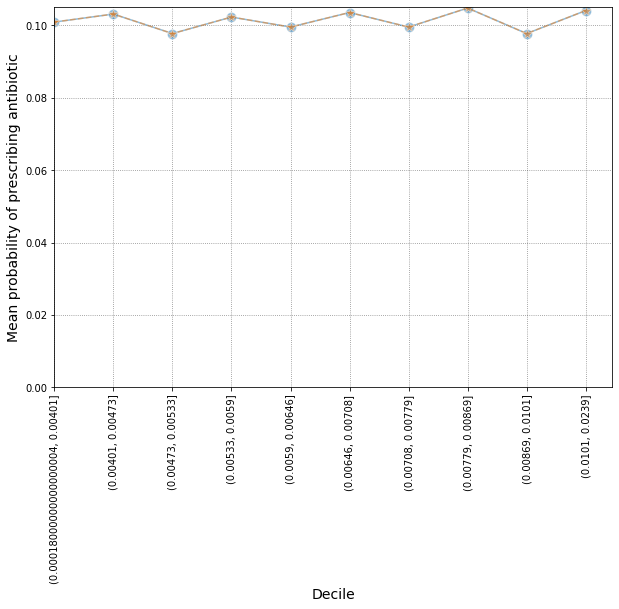


AUROC of LR for deciles with development and validation data: 0.51100 and 0.49142
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00401, 0.00473]  0.050942       -0.069891        0.171775   
1  bins_(0.00473, 0.00533]  0.029226       -0.084790        0.143241   
2   bins_(0.00533, 0.0059]  0.011088       -0.108917        0.131093   
3   bins_(0.0059, 0.00646] -0.005404       -0.121769        0.110961   
4  bins_(0.00646, 0.00708]  0.050968       -0.071325        0.173260   
5  bins_(0.00708, 0.00779] -0.021035       -0.140821        0.098751   
6  bins_(0.00779, 0.00869]  0.100037       -0.027330        0.227403   
7   bins_(0.00869, 0.0101] -0.048022       -0.158281        0.062238   
8    bins_(0.0101, 0.0239]  0.036789       -0.087064        0.160641   

         or  or_lower_95%  or_upper_95%  
0  1.052262      0.932496      1.187410  
1  1.029657      0.918706      1.154008  
2  1.011150      0.896805      1.140074  
3  0.994611    

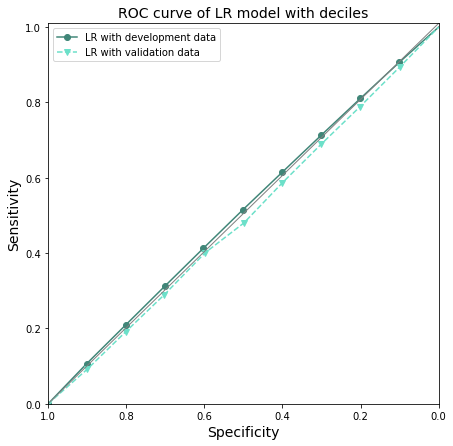

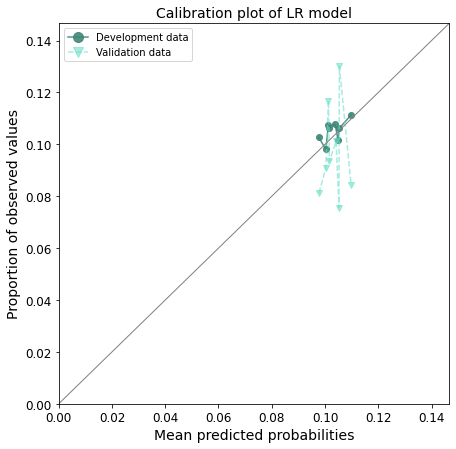

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_incdt_post_2nd_lockdown, prob_pred_throat_no_abs_incdt_post_2nd_lockdown_bin = cox_build('throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown, data_throat_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_build_risk_deciles('throat', 'incdt_post_2nd_lockdown_deciles', prob_pred_throat_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('throat', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3226 total observations, 3215 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 3226
number of events observed = 11
   partial log-likelihood = -58.50
         time fit was run = 2023-10-18 11:48:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.74       2.09       1.34            -1.88             3.36                 0.15                28.68
CCI_cat[T.medium]                2.21       9.14       1.27            -0.27             4.70                 0.76               109.54
CCI_cat[T.high]                  2.09       8.09       1.39            -0.63             4.81                 0.53               122.74
CCI_cat[T.very_high]             0.48       1.61       1.49            -2.45             3.41                 0.09                30.18
age_cat[T.25_34]               -19.86       0.00    9757.55        -19144.30         19104.59                 0.00                  inf
age_cat[T.35_44]               -19.37       0.00    8003.63        -15706.20         15667.46                 0.00                  inf
age_cat[T.45_54]                -0.14       0.87       0.88            -1.88             1.59                 0.15                 4.91
age_cat[T.55_64]                -1.32       0.27       1.22            -3.70             1.07                 0.02                 2.90
age_cat[T.65_74]                -0.35       0.70       0.84            -1.99             1.29                 0.14                 3.64
age_cat[T.75_more]             -19.63       0.00    7728.57        -15167.34         15128.09                 0.00                  inf
antibacterial_brit               0.05       1.06       0.23            -0.40             0.51                 0.67                 1.66
bmi_cat[T.obese]                -1.26       0.28       0.97            -3.17             0.64                 0.04                 1.90
bmi_cat[T.overweight]           -0.87       0.42       1.15            -3.13             1.39                 0.04                 4.00
bmi_cat[T.underweight]         -19.29       0.00   11282.62        -22132.83         22094.25                 0.00                  inf
bmi_cat[T.unknown]              -1.39       0.25       1.11            -3.57             0.79                 0.03                 2.21
ethnicity[T.other]              -0.54       0.58   11842.50        -23211.41         23210.33                 0.00                  inf
ethnicity[T.unknown]            18.23   8.26e+07    7572.61        -14823.81         14860.26                 0.00                  inf
ethnicity[T.white]              17.93   6.10e+07    7572.61        -14824.11         14859.96                 0.00                  inf
flu_vaccine[T.yes]             -18.03       0.00    7114.72        -13962.62         13926.56                 0.00                  inf
imd[T.medium]                   -0.34       0.71       1.01            -2.31             1.64                 0.10                 5.14
imd[T.unaffluent]                0.73       2.08       0.83            -0.89             2.35                 0.41                10.50
imd[T.unknown]                 -18.02       0.00   14297.17        -28039.94         28003.91                 0.00                  inf
imd[T.very_affluent]           -19.04       0.00    5619.54        -11033.14         10995.05                 0.00                  inf
imd[T.very_unaffluent]          -1.29       0.28       1.21            -3.65             1.08                 0.03                 2.96
region[T.east_midlands]          0.70       2.01       1.30           

13256


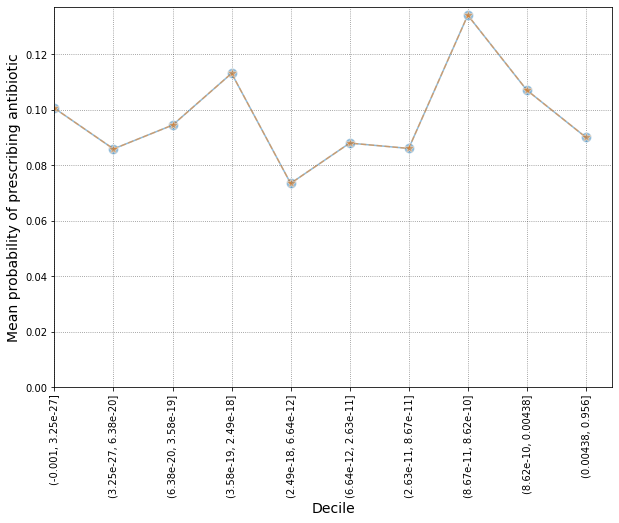


AUROC of LR for deciles with development and validation data: 0.54357 and 0.54776
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0      bins_(0.00438, 0.956] -0.216557       -0.692485        0.259371   
1  bins_(2.49e-18, 6.64e-12] -0.327134       -0.745745        0.091478   
2  bins_(2.63e-11, 8.67e-11] -0.128484       -0.585534        0.328566   
3  bins_(3.25e-27, 6.38e-20] -0.131685       -0.564662        0.301291   
4  bins_(3.58e-19, 2.49e-18]  0.149144       -0.242668        0.540957   
5  bins_(6.38e-20, 3.58e-19] -0.036335       -0.432794        0.360124   
6  bins_(6.64e-12, 2.63e-11] -0.258843       -0.736778        0.219092   
7   bins_(8.62e-10, 0.00438] -0.104473       -0.485743        0.276796   
8  bins_(8.67e-11, 8.62e-10]  0.160546       -0.245667        0.566760   

         or  or_lower_95%  or_upper_95%  
0  0.805287      0.500331      1.296115  
1  0.720987      0.474381      1.095793  
2  0.879427      0.556808      1.3889

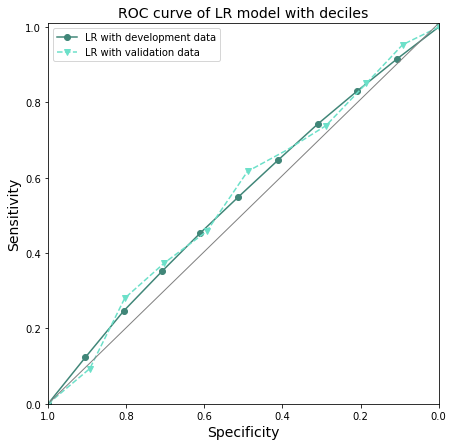

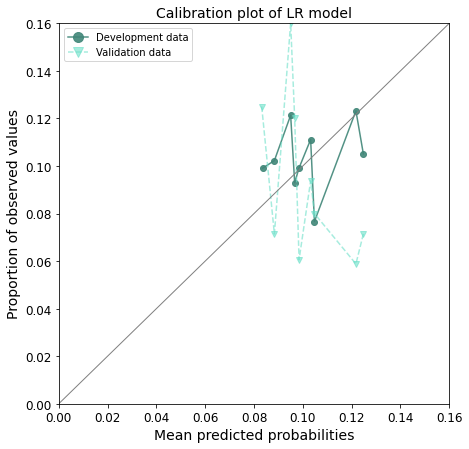

In [41]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_prevl_prepandemic, prob_pred_throat_no_abs_prevl_prepandemic_bin = cox_build('throat', 'prevl_prepandemic', data_throat_prevl_prepandemic, data_throat_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_build_risk_deciles('throat', 'prevl_prepandemic_deciles', prob_pred_throat_no_abs_prevl_prepandemic)
    #calibration plots of lr
    calibration_lr('throat', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2882 total observations, 2861 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 2882
number of events observed = 21
   partial log-likelihood = -139.08
         time fit was run = 2023-10-18 11:48:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.16       0.83            -1.49             1.78                 0.23                 5.91
CCI_cat[T.medium]                0.68       1.97       0.86            -1.00             2.35                 0.37                10.53
CCI_cat[T.high]                 -0.07       0.93       1.25            -2.52             2.37                 0.08                10.68
CCI_cat[T.very_high]             1.26       3.53       0.83            -0.36             2.88                 0.70                17.84
age_cat[T.25_34]                 1.57       4.78       1.11            -0.60             3.73                 0.55                41.89
age_cat[T.35_44]                 0.53       1.69       1.24            -1.91             2.96                 0.15                19.25
age_cat[T.45_54]                 2.14       8.47       1.07             0.04             4.23                 1.04                68.67
age_cat[T.55_64]                 1.07       2.91       1.17            -1.22             3.36                 0.29                28.75
age_cat[T.65_74]               -17.26       0.00    5452.53        -10704.03         10669.51                 0.00                  inf
age_cat[T.75_more]              -0.18       0.83       1.43            -2.99             2.63                 0.05                13.84
antibacterial_brit               0.23       1.26       0.15            -0.06             0.52                 0.94                 1.68
bmi_cat[T.obese]                -0.93       0.40       0.70            -2.30             0.45                 0.10                 1.56
bmi_cat[T.overweight]           -0.44       0.64       0.85            -2.10             1.21                 0.12                 3.36
bmi_cat[T.underweight]           0.49       1.63       1.23            -1.92             2.89                 0.15                18.01
bmi_cat[T.unknown]              -0.79       0.46       0.76            -2.29             0.71                 0.10                 2.04
ethnicity[T.other]              17.50   3.97e+07    6055.45        -11850.97         11885.96                 0.00                  inf
ethnicity[T.unknown]            17.34   3.40e+07    6055.45        -11851.12         11885.81                 0.00                  inf
ethnicity[T.white]              18.31   8.97e+07    6055.45        -11850.15         11886.78                 0.00                  inf
flu_vaccine[T.yes]              -0.46       0.63       0.77            -1.97             1.05                 0.14                 2.87
imd[T.medium]                   -0.30       0.74       0.93            -2.12             1.52                 0.12                 4.58
imd[T.unaffluent]                0.94       2.56       0.71            -0.46             2.34                 0.63                10.38
imd[T.unknown]                   0.67       1.95       1.17            -1.63             2.96                 0.20                19.37
imd[T.very_affluent]             0.81       2.25       0.72            -0.61             2.23                 0.55                 9.30
imd[T.very_unaffluent]          -0.38       0.68       0.93            -2.20             1.44                 0.11                 4.21
region[T.east_midlands]         -1.26       0.28       1.18          

13125


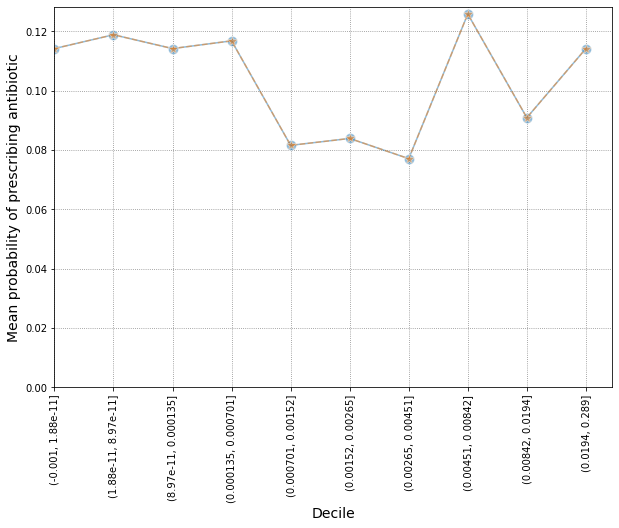


AUROC of LR for deciles with development and validation data: 0.54998 and 0.54196
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000135, 0.000701] -0.124003       -0.497459        0.249454   
1   bins_(0.000701, 0.00152] -0.385706       -0.878382        0.106970   
2    bins_(0.00152, 0.00265] -0.311643       -0.815394        0.192107   
3    bins_(0.00265, 0.00451] -0.375798       -0.822899        0.071304   
4    bins_(0.00451, 0.00842]  0.141853       -0.277977        0.561683   
5     bins_(0.00842, 0.0194] -0.226557       -0.690529        0.237414   
6       bins_(0.0194, 0.289] -0.156258       -0.602495        0.289980   
7  bins_(1.88e-11, 8.97e-11] -0.194889       -0.618757        0.228980   
8  bins_(8.97e-11, 0.000135] -0.050979       -0.472216        0.370257   

         or  or_lower_95%  or_upper_95%  
0  0.883378      0.608074      1.283325  
1  0.679971      0.415455      1.112901  
2  0.732243      0.442465      1.2118

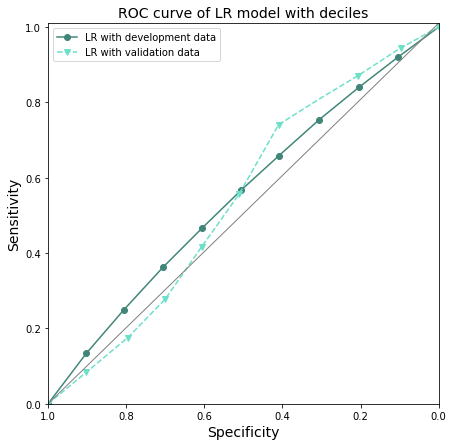

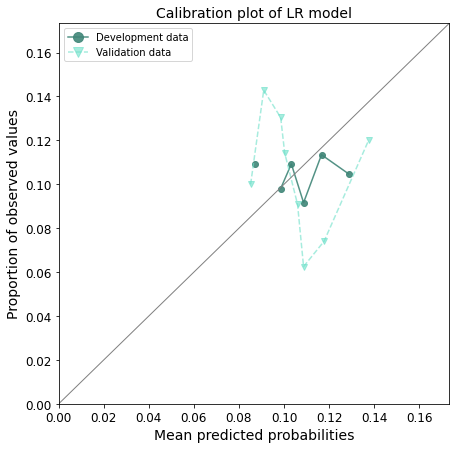

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_prevl_during_pandemic, prob_pred_throat_no_abs_prevl_during_pandemic_bin = cox_build('throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic, data_throat_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_build_risk_deciles('throat', 'prevl_during_pandemic_deciles', prob_pred_throat_no_abs_prevl_during_pandemic)
    #calibration plots of lr
    calibration_lr('throat', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5384 total observations, 5351 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 5384
number of events observed = 33
   partial log-likelihood = -263.01
         time fit was run = 2023-10-18 11:48:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.81       2.24       0.64            -0.44             2.06                 0.64                 7.82
CCI_cat[T.medium]                0.70       2.02       0.68            -0.63             2.03                 0.53                 7.64
CCI_cat[T.high]                 -0.86       0.42       1.16            -3.13             1.41                 0.04                 4.10
CCI_cat[T.very_high]             0.66       1.93       0.71            -0.74             2.05                 0.48                 7.78
age_cat[T.25_34]                -0.11       0.90       0.61            -1.30             1.09                 0.27                 2.98
age_cat[T.35_44]                -0.12       0.89       0.61            -1.32             1.08                 0.27                 2.93
age_cat[T.45_54]                 0.10       1.11       0.56            -1.00             1.21                 0.37                 3.35
age_cat[T.55_64]                -0.13       0.88       0.61            -1.32             1.07                 0.27                 2.90
age_cat[T.65_74]                -1.07       0.34       0.82            -2.67             0.54                 0.07                 1.72
age_cat[T.75_more]              -0.68       0.51       0.71            -2.07             0.71                 0.13                 2.03
antibacterial_brit              -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
bmi_cat[T.obese]                 0.87       2.39       1.04            -1.16             2.91                 0.31                18.33
bmi_cat[T.overweight]            1.69       5.43       1.07            -0.41             3.79                 0.66                44.43
bmi_cat[T.underweight]         -14.73       0.00    2647.24         -5203.23          5173.77                 0.00                  inf
bmi_cat[T.unknown]               1.38       3.97       1.05            -0.68             3.43                 0.51                30.96
ethnicity[T.other]               0.07       1.08       0.77            -1.44             1.59                 0.24                 4.89
ethnicity[T.unknown]            -0.27       0.76       0.67            -1.60             1.05                 0.20                 2.85
ethnicity[T.white]              -0.42       0.66       0.63            -1.66             0.82                 0.19                 2.27
flu_vaccine[T.yes]               0.53       1.70       0.46            -0.37             1.43                 0.69                 4.19
imd[T.medium]                   -0.81       0.44       0.70            -2.18             0.55                 0.11                 1.73
imd[T.unaffluent]                0.40       1.49       0.50            -0.58             1.37                 0.56                 3.95
imd[T.unknown]                   0.56       1.76       0.70            -0.81             1.93                 0.45                 6.92
imd[T.very_affluent]            -0.08       0.93       0.54            -1.14             0.98                 0.32                 2.67
imd[T.very_unaffluent]          -0.78       0.46       0.69            -2.14             0.58                 0.12                 1.78
region[T.east_midlands]         -0.71       0.49       0.87          

13069


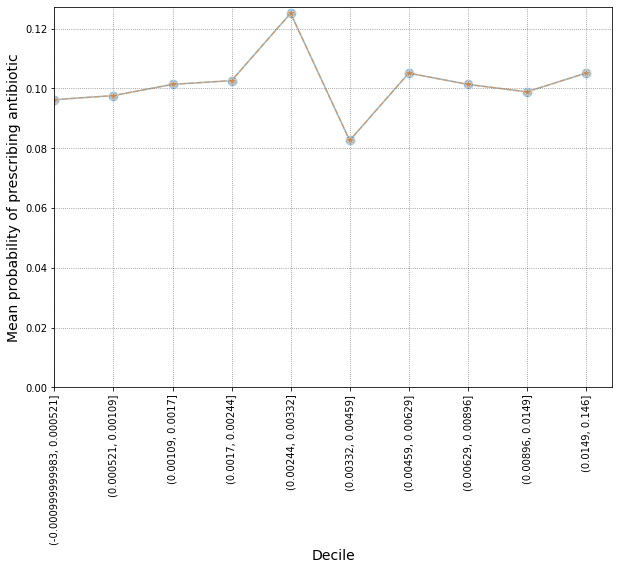


AUROC of LR for deciles with development and validation data: 0.54097 and 0.46992
LR summary:
                   covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000521, 0.00109] -0.262357       -0.629552        0.104838   
1    bins_(0.00109, 0.0017] -0.007924       -0.374199        0.358350   
2    bins_(0.0017, 0.00244]  0.173795       -0.160446        0.508035   
3   bins_(0.00244, 0.00332]  0.220032       -0.073771        0.513836   
4   bins_(0.00332, 0.00459] -0.361549       -0.718917       -0.004182   
5   bins_(0.00459, 0.00629] -0.009528       -0.349773        0.330717   
6   bins_(0.00629, 0.00896]  0.026655       -0.335895        0.389205   
7    bins_(0.00896, 0.0149] -0.013142       -0.336061        0.309778   
8      bins_(0.0149, 0.146]  0.028793       -0.317629        0.375216   

         or  or_lower_95%  or_upper_95%  
0  0.769236      0.532830      1.110531  
1  0.992107      0.687840      1.430966  
2  1.189811      0.851764      1.662022  
3  1.

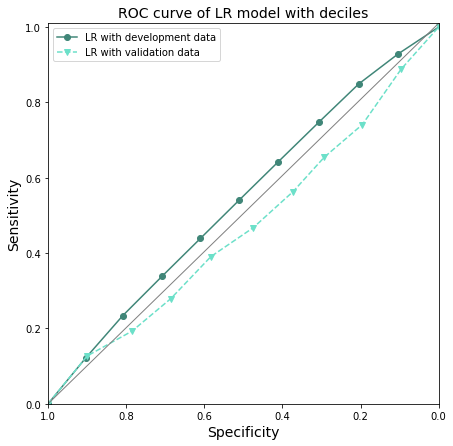

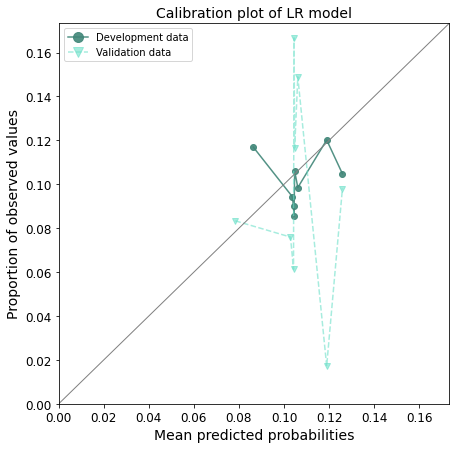

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_throat_no_abs_prevl_post_2nd_lockdown, prob_pred_throat_no_abs_prevl_post_2nd_lockdown_bin = cox_build('throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown, data_throat_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_build_risk_deciles('throat', 'prevl_post_2nd_lockdown_deciles', prob_pred_throat_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('throat', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")